# Compare the CO2 and O2 models to the observations

In this notebook we import pre-run forward models for each of the CO2 and O2 components.\
Then we combine these and compare to the observations.

In [1]:
import os, glob
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta

from acrg.name import name
from acrg.obs import get_obs
from acrg.config.paths import Paths
from acrg.convert import concentration

plt.style.use('tableau-colorblind10')

# sys.path.append(os.environ['FUNCS'])
import apo_plot_info, apo_funcs
from emiss_func import del_o2_n2

/user/home/vf20487/.conda/envs/acrg/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
year = 2015
months = [mm for mm in range(1, 13)] # [11, 12] # [8, 12] #
sites = ['WAO'] #, 'HFD', 'RGL'] #
ocean_sims = ['ecco', 'jena', 'nemo']

save = False

months = [months] if type(months)==int else months
start_dates = {month: datetime(year, month, 1) for month in months}
end_dates = {month: start_date + relativedelta(months=1, seconds=-1) for month, start_date in start_dates.items()}

nrows = len(months) * len(sites)

sites = {site: code for site, code in apo_plot_info.sitecodes.items() if site in sites}

date_str = f'{year}' if months==[mm for mm in range(1, 13)] else \
           f'{year}{str(months[0]).zfill(2)}-{str(months[-1]).zfill(2)}' if len(months)>2 else \
           f'{year}{str(months[0]).zfill(2)}-{year}{str(months[-1]).zfill(2)}' if len(months)==2 else \
           f'{year}{str(months[0]).zfill(2)}'

print(date_str)

2015


## Produce the models

### Import the components timeseries 

In [3]:
ts_data_year = apo_funcs.get_timeseries(sites=sites.keys(), year=year, sources=['ff', 'ocean', 'bc', 'bio_orchidee'])

for site, ts_site in ts_data_year.items():
    if 'co2_ocean_ecco_mth' in ts_site.data_vars:
        ts_data_year[site] = ts_site.drop(['co2_ocean_ecco_mth'])

Finding timeseries for WAO
ff: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ff_timeseries_2015.nc']
ocean: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_2015.nc']
bc: ['/user/work/vf20487/Timeseries/o2_co2/WAO_bc_timeseries_2015.nc']
bio_orchidee: ['/user/work/vf20487/Timeseries/o2_co2/WAO_bio_orchidee_timeseries_2015.nc']
renaming co2-gpp_bio_orchidee: co2_gpp_bio_orchidee
renaming co2-rtot_bio_orchidee: co2_rtot_bio_orchidee

Dropping variables: 
['delta_o2_n2_bc', 'o2_ocean_ecco_mth', 'o2_ocean_nemo_mth']

Data variables: 
['co2_ff', 'o2_ff', 'co2_ocean_ecco', 'o2_ocean_ecco', 'co2_ocean_jena', 'o2_ocean_jena', 'o2_ocean_nemo', 'n2_ocean_nemo', 'co2_ocean_ecco_mth', 'co2_ocean_nemo', 'apo_bc', 'co2_bc', 'o2_bc', 'co2_gpp_bio_orchidee', 'co2_rtot_bio_orchidee']
---------------------------



### Model the biospheric O2 flux

$O_{2,bio} = \alpha_B \times CO_{2,bio}$

In [94]:
for site, ts_site in ts_data_year.items():
    for bio_type in ['gpp', 'rtot']:
        ts_data_year[site][f'o2_{bio_type}_bio_orchidee'] = -1.1 * ts_site[f'co2_{bio_type}_bio_orchidee']

### Combine the components into CO2 and O2 models

Add the components: baseline, fossil fuel, ocean, gpp (bio), and rtot (bio)

In [95]:
models = {site: {spec: {ocean_sim: ts_site[f'{spec}_ff'] + ts_site[f'{spec}_ocean_{ocean_sim}'] +
                                   ts_site[f'{spec}_gpp_bio_orchidee'] + ts_site[f'{spec}_rtot_bio_orchidee']
                        for ocean_sim in ocean_sims}
                 for spec in ['co2', 'o2']}
          for site, ts_site in ts_data_year.items()}

for site, model_site in models.items():
    models[site]['o2'] = {ocean_sim: del_o2_n2(model_sim, ts_data_year[site].n2_ocean_nemo, o2_base=ts_data_year[site].o2_bc)#o2_n2_base=ts_data_year[site].o2_n2_bc)
                          for ocean_sim, model_sim in model_site['o2'].items()}
    models[site]['co2'] = {ocean_sim: model_sim + ts_data_year[site].co2_bc
                           for ocean_sim, model_sim in model_site['co2'].items()}

### Import the observations

In [ ]:
obs_year = {spec: get_obs(list(sites.keys()), spec, f'{year}-01-01', f'{year+1}-01-01', keep_missing=True)
            for spec in ['co2', 'o2']}

Assuming status flag = 0 for all sites
Getting co2 data for WAO...
... changing species from co2 to CO2
... reading /group/chemistry/acrg/obs/WAO/UEA-NDIR_WAO_20100519_CO2-20211221.nc
... slicing from 2015-01-01 00:00:00 to 2015-12-31 23:59:59.999999999
Assuming status flag = 0 for all sites
Getting o2 data for WAO...
... changing species from o2 to O2
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_O2-20211221.nc
... slicing from 2015-01-01 00:00:00 to 2015-12-31 23:59:59.999999999


## Plot the forward models

For each month we plot the CO2 and O2 models on the same axis, as well as the observations

The CO2 models are around 400ppm, and the O2 models are around -600 ppm

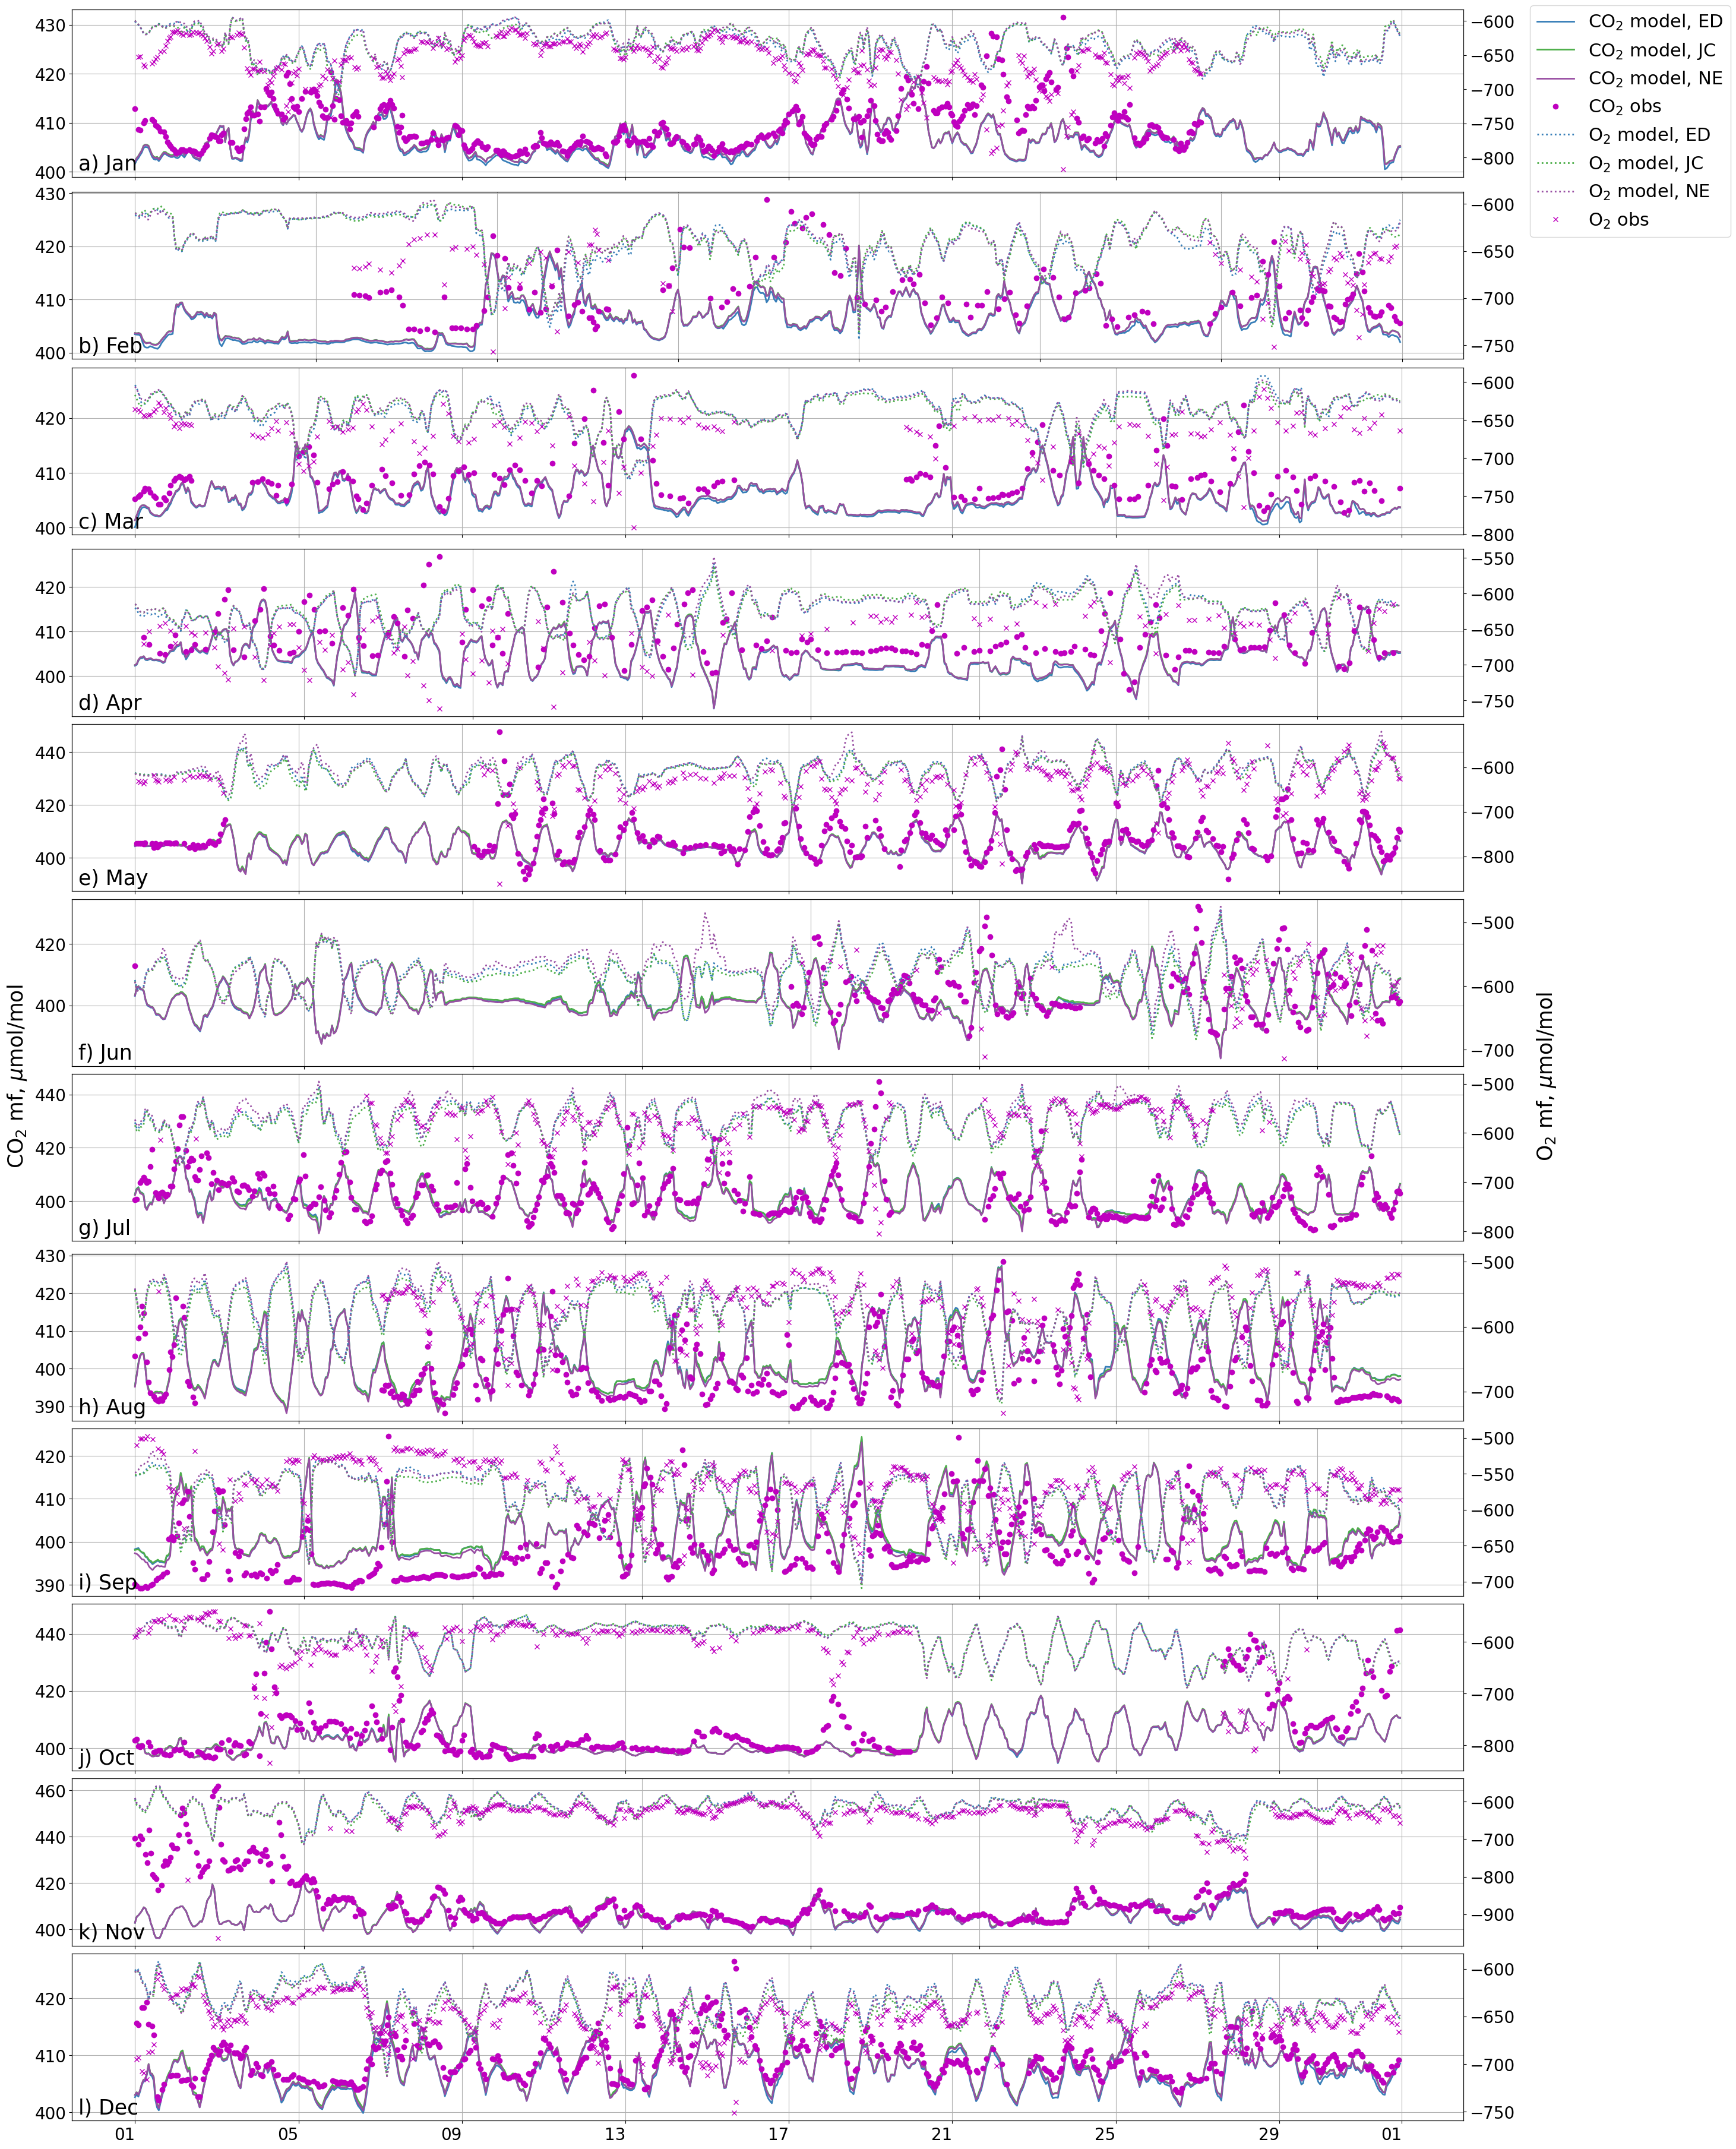

In [160]:
rowsize = 6 if len(sites)==1 and len(months)==1 else 3
fig, axes = plt.subplots(nrows=len(sites)*len(months), ncols=1, 
                         figsize=(25, rowsize*len(sites)*len(months)), constrained_layout=True)
axes_o2 = [ax.twinx() for ax in axes]
axes = np.array([axes]) if len(sites)==1 and len(months)==1 else axes

plot_info = {'co2': {'ls': '-', 'label':r'CO$_2$', 'ax': axes, 'marker': 'o'},
             'o2': {'ls': ':', 'label':r'O$_2$', 'ax': axes_o2, 'marker': 'x'}}
for mm, month in enumerate(months):
    # crop the model timeframe
    models_month = {site: {spec: {ocean_sim: ts_sim.sel(time=slice(start_dates[month], end_dates[month]))
                                  for ocean_sim, ts_sim in ts_spec.items()}
                           for spec, ts_spec in ts_site.items()}
                    for site, ts_site in models.items()}
    obs_month = {spec: {site: obs_site[0].mf.sel(time=slice(start_dates[month], end_dates[month]))
                        for site, obs_site in obs_spec.items()}
                 for spec, obs_spec in obs_year.items()}

    # plot the models and obs
    model_plots = {spec: {site: {sim: ts_sim.plot(ax=info['ax'][ss+mm*len(sites)], color=apo_plot_info.colors[sim.lower()], lw=2,
                                                  ls=info['ls'], label=f'{info["label"]} model, {apo_plot_info.model_names[sim.lower()]}')
                                for sim, ts_sim in ts_site[spec].items()}
                          for ss, (site, ts_site) in enumerate(models_month.items())}
                   for spec, info in plot_info.items()}
    obs_plots = {spec: {site: obs_site.plot(ax=info['ax'][ss+mm*len(sites)], marker=info['marker'], ls='none',
                                            color='m', label=f'{info["label"]} obs')
                        for ss, (site, obs_site) in enumerate(obs_month[spec].items())}
                 for spec, info in plot_info.items()}

# get letters to label the panels
letters = [chr(97 + int(ll - 26*(np.ceil((ll+1)/26)-1)))*int(np.ceil((ll+1)/26))
           for ll in range(len(months)*len(sites))]
if len(sites)>1:
       # label the site
       sites_text = list(sites.values())*len(months)
       [ax.text(0.005, 0.015, f'{letters[aa]}) {sites_text[aa]}', va='bottom', transform=ax.transAxes, fontsize=25) for aa, ax in enumerate(axes)];
elif len(months)>1:
       # label the month
       [ax.text(0.005, 0.015, f'{letters[aa]}) {apo_plot_info.month_names[months[aa]]}', va='bottom', transform=ax.transAxes, fontsize=25)
        for aa, ax in enumerate(axes)];

# format the xticks
myFmt = mdates.DateFormatter('%d')
[[ax.xaxis.set_major_formatter(myFmt) for ax in axes_set] for axes_set in [axes, axes_o2]]
ticks = [[ax.tick_params(labelsize=20, labelrotation=0) for ax in axes_set] for axes_set in [axes, axes_o2]];
[ax.xaxis.set_ticklabels([]) for ax in axes[:-1]];

# get the labels for the legend
lines = []
labels = []
for ax in [axes[0], axes_o2[0]]:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)
# add the legend outside of the top axis
# legend = axes[0].legend(lines, labels, fontsize=20, bbox_to_anchor=(1.04, 1.04), loc='upper left')
legend = fig.legend(lines, labels, bbox_to_anchor=(1.15, 1.005), fontsize=22)

# add a grid
grid = [ax.grid() for ax in axes]
# add axis labels
xlabels = [ax.set_xlabel('') for ax in axes]
ylabels = [[ax.set_ylabel('') for ax in axes_set] for axes_set in [axes, axes_o2]]
ylabels = [fig.text(x, 0.5, f'{label} mf, $\mu$mol/mol', va='center', ha='center', rotation='vertical', fontsize=25)
           for x, label in {-0.01:r'CO$_2$', 1.02:r'O$_2$'}.items()]

## Examine the correlations

### Calculate the correlations

In [119]:
rmse = {site: {spec: {month: {ocean_sim: (((model_ocean.sel(time=slice(start_dates[month], end_dates[month])) - 
                                            obs_year[spec][site][0].mf.sel(time=slice(start_dates[month], end_dates[month])))**2).mean().values)**0.5
                              for ocean_sim, model_ocean in model_spec.items() if len(obs_year[spec][site])>0}
                       for month in months}
               for spec, model_spec in model_site.items()}
        for site, model_site in models.items()}

correlations = {site: {spec: {month: {ocean_sim: float(xr.corr(obs_year[spec][site][0].mf.sel(time=slice(start_dates[month], end_dates[month])),
                                                               model_ocean.sel(time=slice(start_dates[month], end_dates[month]))))**2
                                      for ocean_sim, model_ocean in model_spec.items() if len(obs_year[spec][site])>0}
                              for month in months}
                       for spec, model_spec in model_site.items()}
                for site, model_site in models.items()}

### Plot the correlations

Saving to /user/work/vf20487/Figures/Timeseries/CO2_O2_correlations_WAO_2015.png


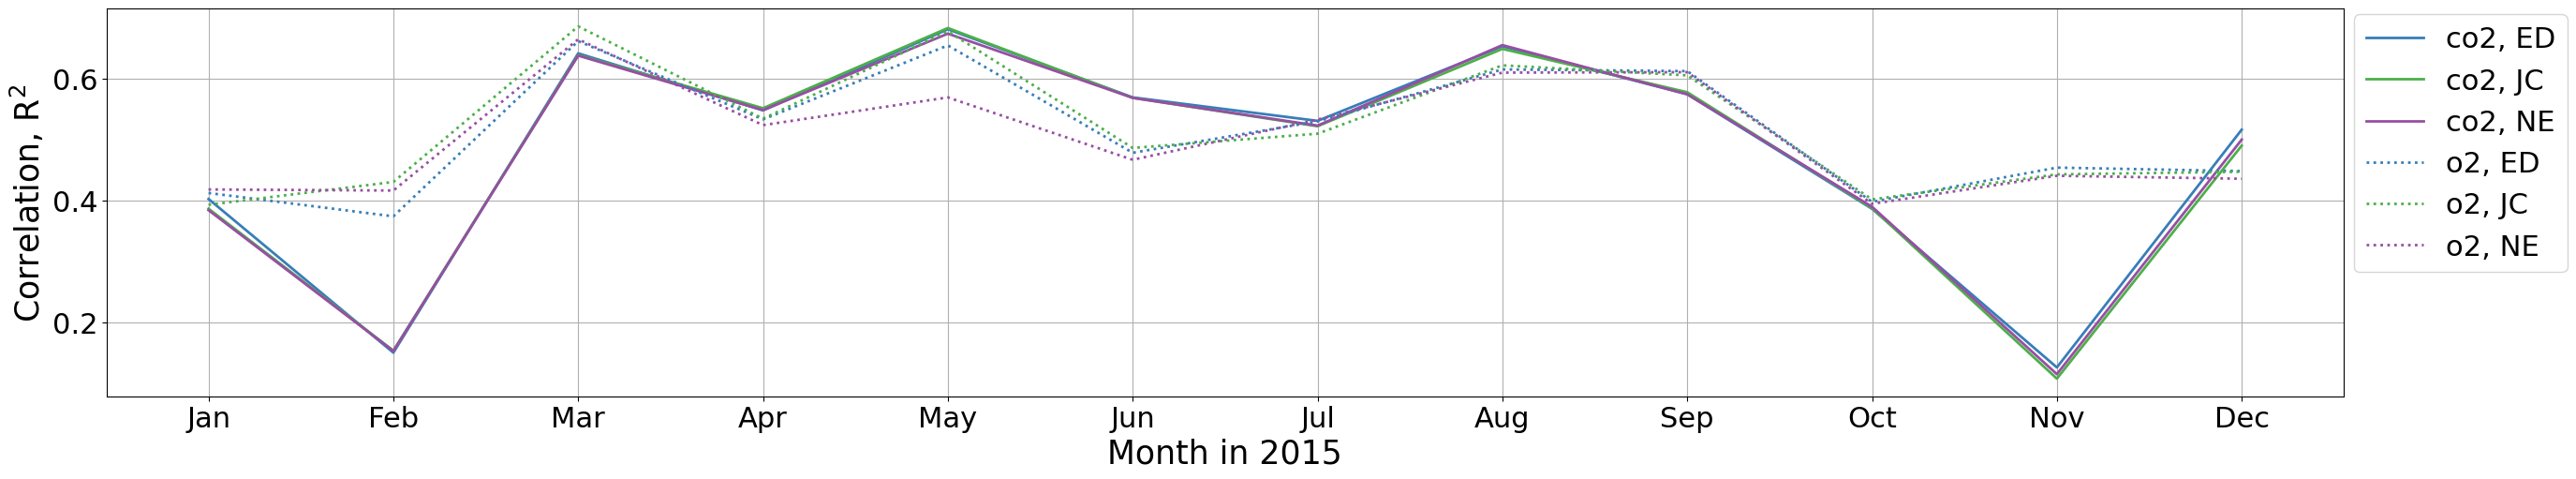

In [133]:
plot_rmse = False
if len(months)>=12:
    sites_plot = ['WAO']
    sites_plot = [site for site in sites_plot if site in sites]

    ls = {'co2': '-', 'o2': ':'}

    num_rows = [2 if plot_rmse else 1][0]*len(sites_plot)
    fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(25, 5*num_rows), sharex=True, constrained_layout=True)
    axes = axes if plot_rmse else np.array([axes])

    corr_plot = [[[axes[ss].plot(apo_plot_info.month_names.values(), [rr[sim] for rr in corr_spec.values()],
                                color=apo_plot_info.colors[sim], label=f'{spec}, {apo_plot_info.model_names[sim]}', ls=ls[spec], lw=2)
                   for sim in ocean_sims]
                  for spec, corr_spec in corr_site.items()]
                 for ss, (site, corr_site) in enumerate(correlations.items())]
    if plot_rmse:
        rmse_plot = [[[axes[len(sites_plot)+ss].plot(apo_plot_info.month_names.values(), [rr[sim] for rr in rmse_spec.values()],
                                    color=apo_plot_info.colors[sim], ls=ls[spec], lw=2)#, label=f'{spec}, {apo_plot_info.model_names[sim]}'
                    for sim in ocean_sims]
                    for spec, rmse_spec in rmse_site.items()]
                    for ss, (site, rmse_site) in enumerate(rmse.items())]

    ticks = [ax.tick_params(labelsize=22) for ax in axes]
    legend = fig.legend(bbox_to_anchor=(1.1, 1.01), fontsize=22)
    grid = [ax.grid() for ax in axes]

    # add axis labels
    xlabels = [ax.set_xlabel('') for ax in axes]
    xlabel = axes[-1].set_xlabel(f'Month in {year}', fontsize=25)
    ylabels_str = [r'Correlation, R$^2$', 'RMSE, per meg'] if plot_rmse else [r'Correlation, R$^2$']
    ylabels = [axes[ll].set_ylabel(label, fontsize=25) for ll, label in enumerate(ylabels_str)]
    if plot_rmse:
        ax_labels = [ax.text(0.005, 0.015, f'{chr(97+aa)})', va='bottom', transform=ax.transAxes, fontsize=25) for aa, ax in enumerate(axes)]

    date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
    filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries',
                            f'CO2_O2_correlations_{"-".join(sites_plot)}_{date_str}.png')
    
    print(f'Saving to {filename}')
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

In [161]:
print('\nCorrelation')
print_corr = [[[print(f'{spec} {site}, {apo_plot_info.month_names[month]} correlation:    ECCO: {corr_month["ecco"]:.2f};   Jena: {corr_month["jena"]:.2f};   '+
                     f'NEMO: {corr_month["nemo"]:.2f}')
                for month, corr_month in corr_spec.items()]
               for spec, corr_spec in corr_site.items()] 
              for site, corr_site in correlations.items()]

print('RMSE')
print_rmse = [[[print(f'{spec} {site}, {apo_plot_info.month_names[month]} rmse:    ECCO: {rmse_month["ecco"]:.2f};   Jena: {rmse_month["jena"]:.2f};   '+
                     f'NEMO: {rmse_month["nemo"]:.2f}')
                for month, rmse_month in rmse_spec.items()]
               for spec, rmse_spec in rmse_site.items()] 
              for site, rmse_site in rmse.items()]


Correlation
co2 WAO, Jan correlation:    ECCO: 0.40;   Jena: 0.39;   NEMO: 0.38
co2 WAO, Feb correlation:    ECCO: 0.15;   Jena: 0.15;   NEMO: 0.15
co2 WAO, Mar correlation:    ECCO: 0.64;   Jena: 0.64;   NEMO: 0.64
co2 WAO, Apr correlation:    ECCO: 0.55;   Jena: 0.55;   NEMO: 0.55
co2 WAO, May correlation:    ECCO: 0.68;   Jena: 0.68;   NEMO: 0.67
co2 WAO, Jun correlation:    ECCO: 0.57;   Jena: 0.57;   NEMO: 0.57
co2 WAO, Jul correlation:    ECCO: 0.53;   Jena: 0.52;   NEMO: 0.52
co2 WAO, Aug correlation:    ECCO: 0.65;   Jena: 0.65;   NEMO: 0.66
co2 WAO, Sep correlation:    ECCO: 0.57;   Jena: 0.58;   NEMO: 0.57
co2 WAO, Oct correlation:    ECCO: 0.39;   Jena: 0.39;   NEMO: 0.39
co2 WAO, Nov correlation:    ECCO: 0.13;   Jena: 0.11;   NEMO: 0.12
co2 WAO, Dec correlation:    ECCO: 0.52;   Jena: 0.49;   NEMO: 0.50
o2 WAO, Jan correlation:    ECCO: 0.41;   Jena: 0.39;   NEMO: 0.42
o2 WAO, Feb correlation:    ECCO: 0.37;   Jena: 0.43;   NEMO: 0.42
o2 WAO, Mar correlation:    ECCO: 0.6

### Look at the correlation for different resolutions

In [147]:
model_diff_res = {site: {spec: {ocean_sim: {res_name: model_sim.resample(time=res).mean()
                                            for res_name, res in {'hour': '1H', 'day': '1D', 'week': 'W', 'month': '1M'}.items()}
                                for ocean_sim, model_sim in model_spec.items()}
                         for spec, model_spec in model_site.items()}
                  for site, model_site in models.items()}
obs_diff_res = {spec: {site: {res_name: obs_site[0].mf.resample(time=res).mean()
                              for res_name, res in {'hour': '1H', 'day': '1D', 'week': 'W', 'month': '1M'}.items()}
                       for site, obs_site in obs_spec.items()}
                for spec, obs_spec in obs_year.items()}

In [154]:
rmse_diff_res = {site: {spec: {ocean_sim: {res: {month: (((model_res.sel(time=slice(start_dates[month], end_dates[month])) - 
                                                           obs_diff_res[spec][site][res].sel(time=slice(start_dates[month], end_dates[month])))**2).mean().values)**0.5
                                                 for month in months}
                                           for res, model_res in model_sim.items()}
                                for ocean_sim, model_sim in model_spec.items()}
                        for spec, model_spec in model_site.items()}
                for site, model_site in model_diff_res.items()}

correlations_diff_res = {site: {spec: {ocean_sim: {res: {month: xr.corr(obs_diff_res[spec][site][res].sel(time=slice(start_dates[month], end_dates[month])),
                                                                        model_res.sel(time=slice(start_dates[month], end_dates[month])))**2
                                                         for month in months}
                                                   for res, model_res in model_sim.items()}
                                        for ocean_sim, model_sim in model_spec.items()}
                                for spec, model_spec in model_site.items()}
                         for site, model_site in model_diff_res.items()}

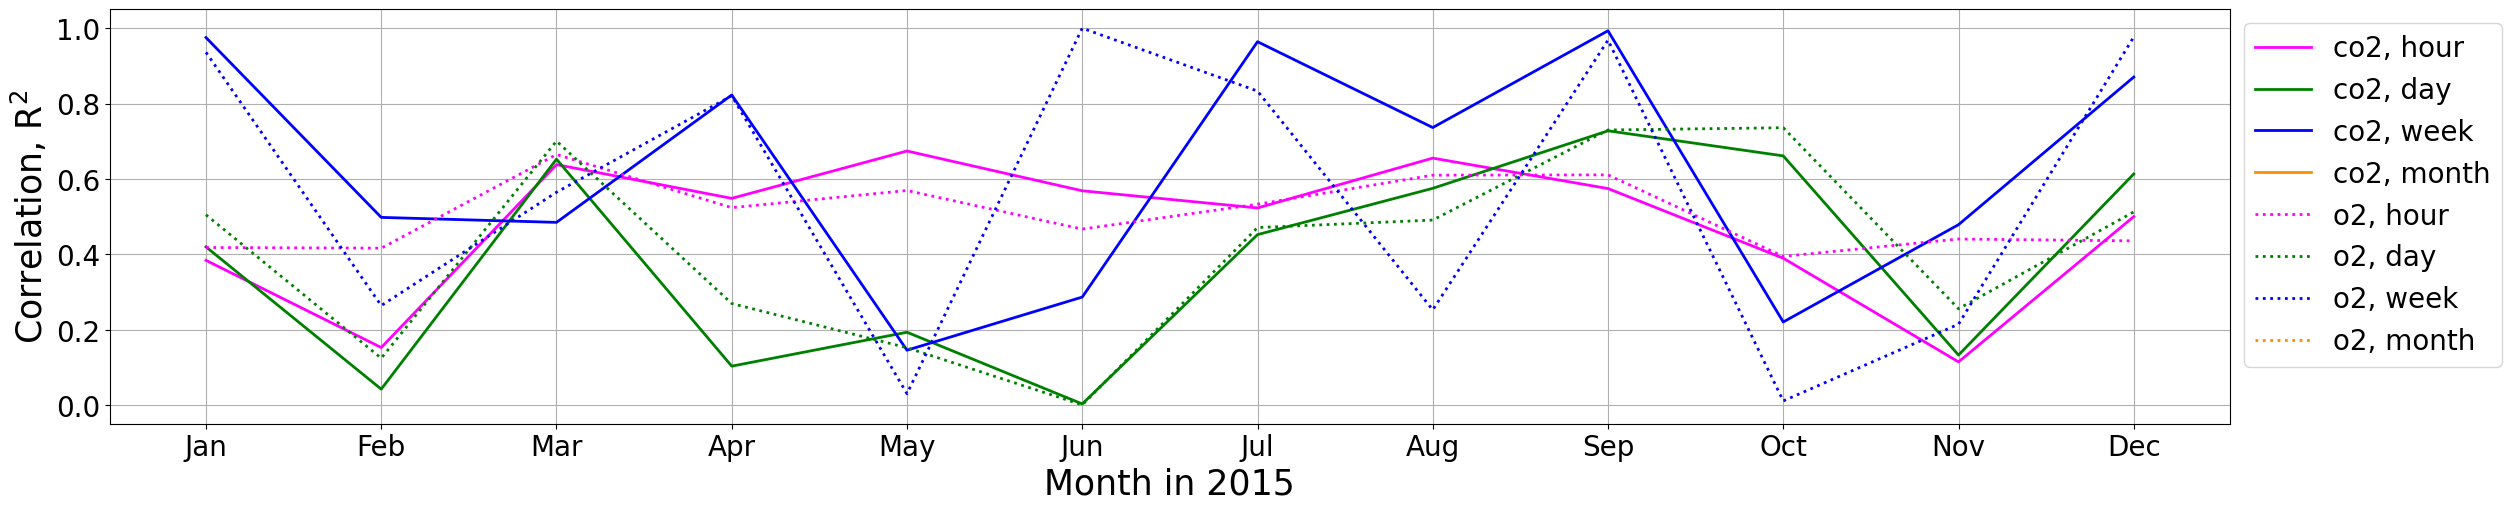

In [158]:
if len(months)>=12:
    sites_plot = ['WAO']
    model_plot = 'nemo'
    
    res_colors = {'hour': 'magenta', 'day': 'green', 'week': 'blue', 'month': 'darkorange'}

    num_rows = [2 if plot_rmse else 1][0]*len(sites_plot)
    fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(25, 5*num_rows), sharex=True, constrained_layout=True)
    axes = axes if plot_rmse else np.array([axes])

    corr_plot = [[[axes[ss].plot(apo_plot_info.month_names.values(), corr_res.values(),
                                 color=res_colors[res], label=f'{spec}, {res}', ls=ls[spec], lw=2)
                   for res, corr_res in corr_spec[model_plot].items()] 
                  for spec, corr_spec in corr_site.items()]
                 for ss, corr_site in enumerate(correlations_diff_res.values())]
    if plot_rmse:
        rmse_plot = [[[axes[len(sites_plot)+ss].plot(apo_plot_info.month_names.values(), rmse_res.values(),
                                                    color=res_colors[res], ls=ls[spec], lw=2)
                       for res, rmse_res in rmse_spec[model_plot].items()]
                     for spec, rmse_spec in rmse_site.items()]
                    for ss, rmse_site in enumerate(rmse_diff_res.values())]

    ticks = [ax.tick_params(labelsize=20) for ax in axes]
    # legend = axes[0].legend(loc='lower left', fontsize=16)
    legend = axes[0].legend(bbox_to_anchor=(1,1), loc="upper left", fontsize=20)
    grid = [ax.grid() for ax in axes]
    xlabels = [ax.set_xlabel('') for ax in axes]
    xlabel = axes[-1].set_xlabel(f'Month in {year}', fontsize=25)
    ylabels = [axes[ll].set_ylabel(label, fontsize=25) for ll, label in enumerate(ylabels_str)]
    if plot_rmse:
        ax_labels = [ax.text(0.005, 0.015, f'{chr(97+aa)})', va='bottom', transform=ax.transAxes, fontsize=25) for aa, ax in enumerate(axes)]

    date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
    filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                            f'CO2_O2_correlations_{"-".join(sites_plot)}_{date_str}.png')

## Plot the CO2 components

In [5]:
ts_data_year['WAO']['co2_bio_orchidee'] = ts_data_year['WAO'].co2_gpp_bio_orchidee + ts_data_year['WAO'].co2_rtot_bio_orchidee

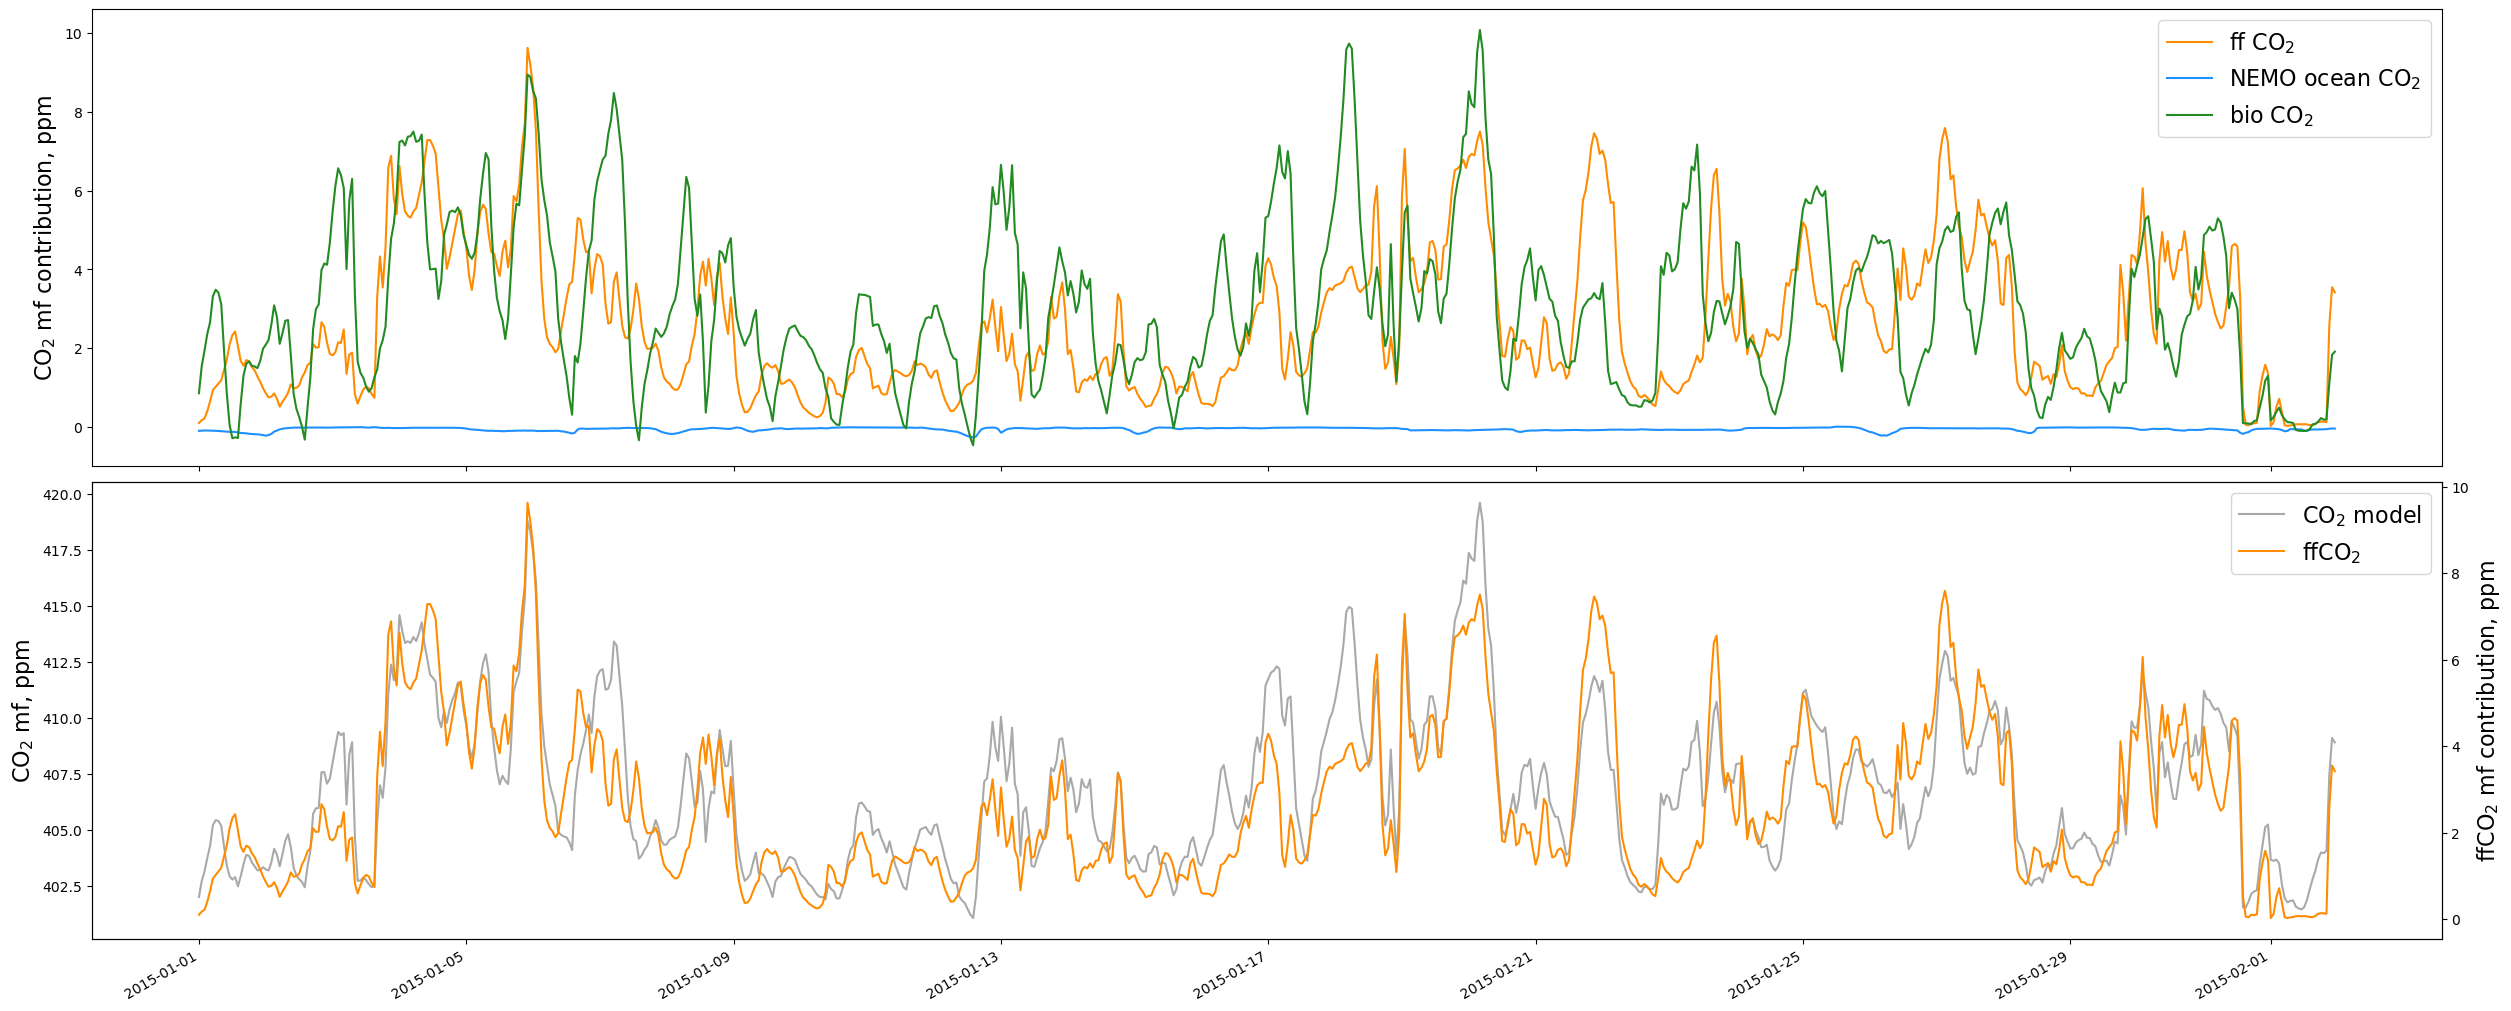

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(25, 10), sharex=True, constrained_layout=True)
ax2 = axes[1].twinx()

vars_plot = {'ff': {'var': 'co2_ff', 'color': 'darkorange'},
             'NEMO ocean': {'var': 'co2_ocean_nemo', 'color': 'dodgerblue'},
             'bio': {'var': 'co2_bio_orchidee', 'color': 'forestgreen'}}

[ts_data_year['WAO'][info['var']].sel(time=slice('2015-01-01', '2015-02-01')).plot(ax=axes[0], color=info['color'], label=var+r' CO$_2$')
 for var, info in vars_plot.items()];
legend = axes[0].legend(fontsize=16)

# plot total CO2 model
ts_co2 = ts_data_year['WAO'].co2_ff + ts_data_year['WAO'].co2_bio_orchidee + ts_data_year['WAO'].co2_ocean_nemo + ts_data_year['WAO'].co2_bc
ts_co2.sel(time=slice('2015-01-01', '2015-02-01')).plot(ax=axes[1], color='darkgrey', label=r'CO$_2$ model');
ts_data_year['WAO'].co2_ff.sel(time=slice('2015-01-01', '2015-02-01')).plot(ax=ax2, color='darkorange', label=r'ffCO$_2$')

# get the labels for the legend
lines = []
labels = []
for ax in [axes[1], ax2]:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)
# add the legend outside of the top axis
# legend = axes[0].legend(lines, labels, fontsize=20, bbox_to_anchor=(1.04, 1.04), loc='upper left')
legend = axes[1].legend(lines, labels, fontsize=16)

xlabel = [ax.set_xlabel('') for ax in axes]
ylabel = axes[0].set_ylabel(r'CO$_2$ mf contribution, ppm', fontsize=16)
ylabel = axes[1].set_ylabel(r'CO$_2$ mf, ppm', fontsize=16)
ylabel = ax2.set_ylabel(r'ffCO$_2$ mf contribution, ppm', fontsize=16)#, rotation=270)

In [4]:
ts_data_year['WAO']

<xarray.Dataset>
Dimensions:                (time: 8760)
Coordinates:
  * time                   (time) datetime64[ns] 2015-01-01 ... 2015-12-31T23...
Data variables: (12/14)
    co2_ff                 (time) float32 0.09943 0.1709 0.2169 ... 2.168 2.38
    o2_ff                  (time) float64 -0.17 -0.2835 ... -3.421 -3.756
    co2_ocean_ecco         (time) float32 -0.5004 -0.4909 ... -0.8675 -0.7997
    o2_ocean_ecco          (time) float64 -1.8 -1.729 -1.658 ... -1.584 -1.751
    co2_ocean_jena         (time) float64 -0.0001771 -0.0002638 ... -0.0005242
    o2_ocean_jena          (time) float64 -1.529 -1.521 -1.517 ... -1.497 -1.585
    ...                     ...
    co2_ocean_nemo         (time) float32 -0.09943 -0.09556 ... -0.1366 -0.1229
    apo_bc                 (time) float64 -319.1 -318.9 -318.8 ... -329.6 -329.7
    co2_bc                 (time) float64 401.1 401.1 401.1 ... 402.7 402.6
    o2_bc                  (time) float64 2.093e+05 2.093e+05 ... 2.093e+05
    co2_gpp_bio_orchidee   (time) float64 0.0 0.0 0.0 ... -0.6104 -0.5482 -0.641
    co2_rtot_bio_orchidee  (time) float64 0.8562 1.545 1.935 ... 4.541 4.981